# Сегментация медицинских снимков

## Загрузка данных

---
Датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>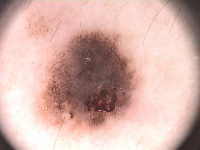</td><td>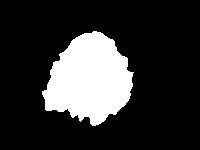</td></tr></table>

Это фотографии двух типов **поражений кожи:** меланомы и родинки.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

In [ ]:
!ls

PH2Dataset  PH2Dataset.rar  sample_data


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Приведем к разрешению 256 х 256 и нормализуем:

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

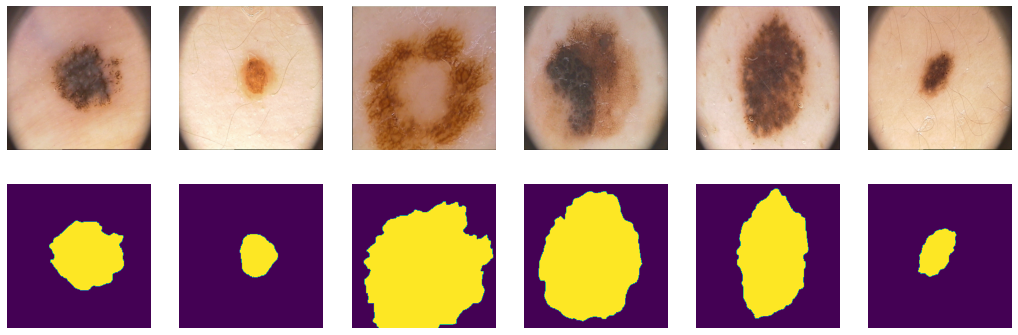

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Реализация различных архитектур

### SegNet

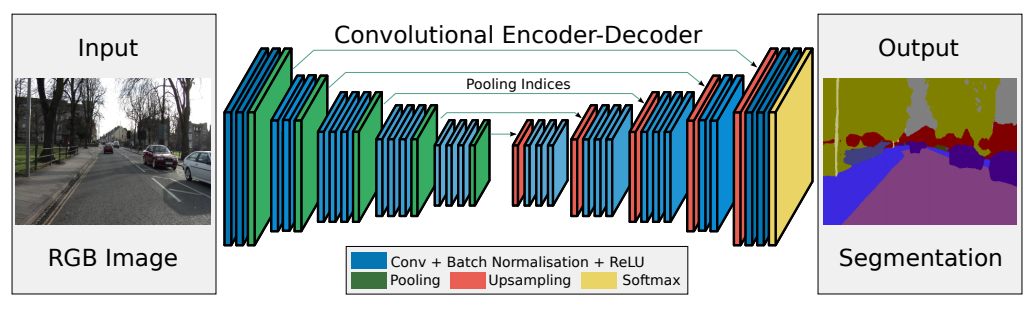

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module): #На выходе - 1 x 256 x 256 фото (тк сегментация бинарная)
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)# 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        #bottleneck
        #self.bottleneck_conv
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool4 = nn.MaxPool2d(2, 2, return_indices=True) # 16 -> 8

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 8 -> 16
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample4 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
        #self.clf = nn.Sigmoid()

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0, idx0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1, idx1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2, idx2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3, idx3 = self.pool3(e3)
        e4 = self.enc_conv4(p3)
        p4, idx4 = self.pool4(e4)


        # decoder
        u0 = self.upsample0(p4, idx4)
        d0 = self.dec_conv0(u0)
        u1 = self.upsample1(d0, idx3)
        d1 = self.dec_conv1(u1)
        u2 = self.upsample2(d1, idx2)
        d2 = self.dec_conv2(u2)
        u3 = self.upsample3(d2, idx1)
        d3 = self.dec_conv3(u3)
        u4 = self.upsample4(d3, idx0)
        d4 = self.dec_conv4(u4)

        #classifier
        return d4

#WITH HELP OF - https://github.com/say4n/pytorch-segnet/blob/master/src/model.py

### Метрика

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$


![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresholds

    return thresholded  #

### Функция потерь


$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(labels, logits):
    # TODO
    # please don't use nn.BCELoss. write it from scratch
    return torch.sum(logits - logits * labels + torch.log(1 + torch.exp(-logits)))

### Обучение

In [ ]:
def predict(X):
    return torch.sigmoid(X) > 0.5

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch  = X_batch.cuda()
            Y_batch = Y_batch.cuda()
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model.forward(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model.forward(X_batch).detach().to('cpu')# detach and put into cpu
        Y_hat = predict(Y_hat)

        # Visualize tools
        clear_output(wait=True)
        for k in range(5):
            plt.subplot(2, 5, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 5, k+6)
            plt.imshow(Y_hat[k, 0])
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.cuda()
        Y_pred = predict(model.forward(X_batch))
        scores += metric(Y_pred, Y_label.cuda()).mean().item()

    return scores/len(data)

In [ ]:
model = SegNet().cuda()

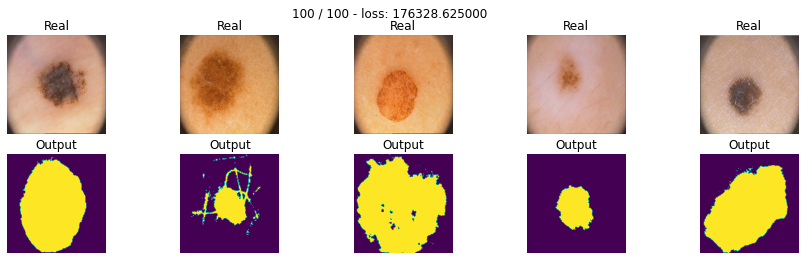

In [ ]:
max_epochs = 100
optim = torch.optim.Adam(model.parameters())
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7060000181198121

### Focal loss: https://arxiv.org/pdf/1708.02002.pdf

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
 $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    return -torch.sum(((1 - torch.sigmoid(y_pred)) ** gamma) * y_real * torch.log(torch.sigmoid(y_pred) + eps) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred) + eps))

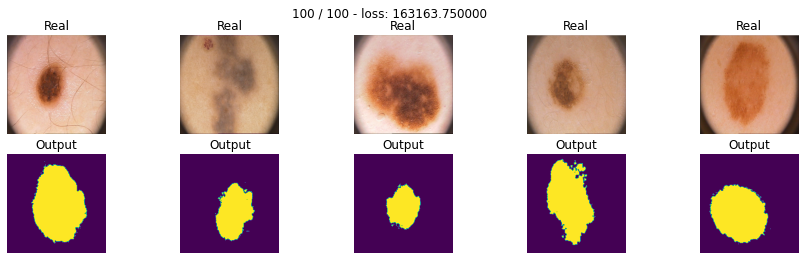

In [ ]:
model_focal = SegNet().cuda()

max_epochs = 100
optimizer = torch.optim.Adam(model_focal.parameters())
train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.6500000059604645

-----------------------------------------------------------------------------------------

### U-Net

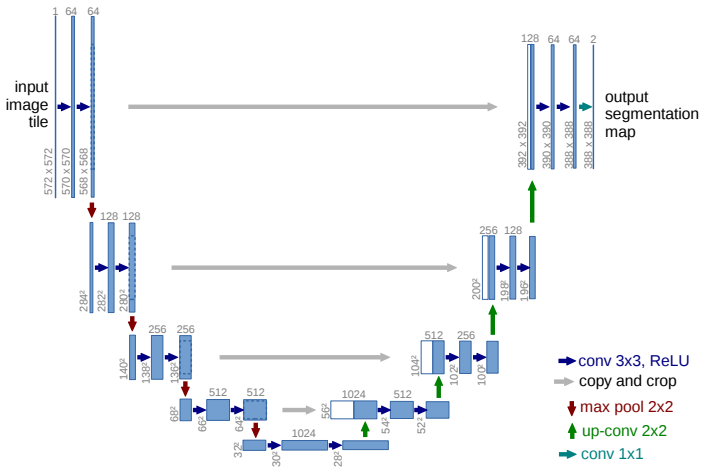

In [ ]:
from torchvision.transforms import CenterCrop

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, 2)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2)
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(512, 1024, 3),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, 3),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, 2, 2, 0) #или вместо этого Upsample и Conv2d
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, 3),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(512, 256, 2, 2, 0)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, 3),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(256, 128, 2, 2, 0)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(128, 64, 2, 2, 0)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )
        self.out = nn.Conv2d(64, 1, 1)



    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc_conv4(p3)

        # decoder
        u0 = self.upsample0(e4)
        d0 = self.dec_conv0(torch.cat([CenterCrop(size=u0.shape[2])(e3), u0], axis=1))
        u1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat([CenterCrop(size=u1.shape[2])(e2), u1], axis=1))
        u2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat([CenterCrop(size=u2.shape[2])(e1), u2], axis=1))
        u3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat([CenterCrop(size=u3.shape[2])(e0), u3], axis=1))
        out = self.out(d3)
        return out

#WITH HELP OF https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201

In [ ]:
unet_model = UNet().cuda()

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)